# Lab 3 - Recommendor System

- Scott Gozdzialski
- Adam Baca
- Zoheb Allam
- Ethan Graham

The dataset can be found here http://www2.informatik.uni-freiburg.de/~cziegler/BX/

### Business Understanding 1

Business today is built upon different things based upon the sector they fullfill.  I business built on customer sales is different that a business build on services provided.  But, all business is built upon the idea of repeat customers. we will be focusing on a book store.  This model will be running through a list of ratings of books that have been rated by customers.  These customers who have rated the book will most likely return; so, we will be building a recommendor system based upon these ratings.  By recommending new books to customers who have already inveseted in the system we are more likely to have them reutrn.  Also, we can use the system to draw in new customers based upon the books they are insterseted in reading. 

Recommendor systems are an important part of business as the repeat customer is very important. Our recommendor system can be used for more that just books.  In any industry where customers rate the products or service of busniesses can benifit from recommendor systems.


In [1]:
import graphlab as gl
import numpy as np
import pandas as pd
from __future__ import print_function

## Data Understanding  1 - Meaning

We will be using as list of book ratings from http://www2.informatik.uni-freiburg.de/~cziegler/BX/ website.  These ratings are stored in multiple files.  The one we will be forcusing on is  BX-Books-Ratings.   The different files are stored in CSV files, but they are seperated with semicolons which cause a error, so we will do some very minor clean up with MSexcel, which is not shown here.  We seperate the the files in to a true CSV in excel and end up with a few rows that are not clean and drop them.  We also take the ISBN of the books and replace them with the title in excel.  This has makes the files and recommendor system results more human readable.  After this clean up we end up with somewhere around 900K records.  We will now start are clean up with pandas.

The rating system is a ten point system between 1 and 10 with 0 meaning the book was read but not rated.  The records with a zero will be first dropped since they do not represent user ratings in a true sense.

In [2]:
path = "home/UserReviewTitle.csv"

df = pd.read_csv('/home/scott/UserReviewTitle.csv',sep = ",")

First we want to see what we are looking at in the dataframe we have loaded.

In [3]:
df = df[df.rating != 0]
df.describe

<bound method DataFrame.describe of             id  rating                                              title
2            8       5                                       Clara Callan
5            8       7                      Goodbye to the Buttermilk Sky
7            8       5                                           Jane Doe
8            8       6  More Cunning Than Man: A Social History of Rat...
12           8       5                                 The Middle Stories
14           8       6       The Witchfinder (Amos Walker Mystery Series)
17           8       5            Where You'll Find Me: And Other Stories
18           9       6               Beloved (Plume Contemporary Fiction)
22          12      10  If I'd Known Then What I Know Now: Why Not Lea...
23          14       6                           Flood : Mississippi 1927
24          14       5  Mary-Kate &amp; Ashley Switching Goals (Mary-K...
25          14       5                       Tell Me This Isn't Happening
27

We see that we have three different columns. Df.describe shows four, the first is the row count.

Next we have

- id : This is the used Id for the user who rated the book.
- rating :  This is the rating the user gave the book.
- title : This is the book title.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351862 entries, 2 to 941139
Data columns (total 3 columns):
id        351862 non-null int64
rating    351862 non-null int64
title     351862 non-null object
dtypes: int64(2), object(1)
memory usage: 10.7+ MB


The data was loaded properly.  Id and rating are integers, while title is an object.  The only change I would think to make is change Id to an object since there is no relationship among users.

Next, we are going to parse down the dataframe from 941K records. 

The first cut will be to drop any title that is rated less than 10 times.  Fifteen was chosen because with  such a large dataset to start with we are looking for the items with the strongest response to start.  If 10 leaves us with a weak result we will change our search criteria.

This will be acheived by grouping the dataframe by title.  Any title with more than 10 counts on their group will be kept.  

******** admin note we will not desribe how we parse down the df unless it is different for the above.

In [5]:
df2 = df.groupby('title').filter(lambda x: len(x) >= 10)

In [6]:
df2.shape


(142317, 3)

We end up with over 142K records, so the next step is to parse the dataframe down by dropping any record of any user who has not rate 15 books.  This will leave us with books rated 5 times or more by user who have rate atleast 5 times. This will give a strong correlation to use for our recommender system.

In [7]:
df3 = df2.groupby('id').filter(lambda x: len(x) >= 5)

In [8]:
df3.shape

(94737, 3)

We end up with 94K records for our reommender sytsem.  This is still a very strong number, we have books rated over 10 times each and users who have rated books 5 times or more.  

## Data Understanding 2 - Visualization
We will look at the different ratings to see what the distribution is of our final dataframe.  We are looing for anything odd, like if all the rating are super high we will have to include more of the rating in the dataframe.  

We will not be looking at title beause it is an object and will not work; also, we tried to count the titles and display the differnt counts and it filled the memory and crashed the computer. 

This non-commercial license of GraphLab Create for academic use is assigned to sgozdzialski@smu.edu and will expire on December 07, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1512845577.log


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89b9fd7d90>]], dtype=object)

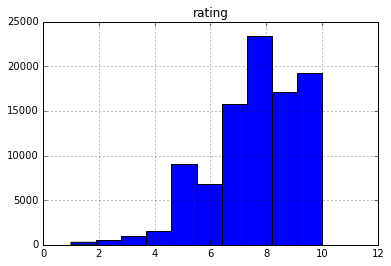

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
df3.hist(column='rating')

The rating distribution does not look bad.  There are all ratings are used, and they are close to a normal distribution.  They are alittle sckewed, but that will not effect our recommender system.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89ba0805d0>]], dtype=object)

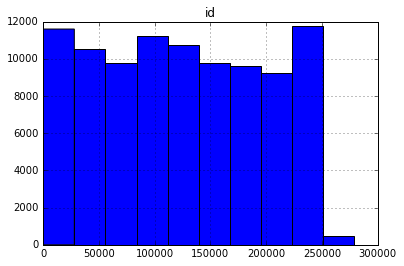

In [10]:
df3.hist(column='id')

We are looking to see if there are any users who have a higher number of ratings thatn anyone else. This can cause some issues with the recommener system.  There are no real group of user who have higher or lower rating than the rest. The lower bar on the right is beacuse the graph is bucketted.  There are far fewer users in the last bucket than the other buckets causing the lower bar.


## Model and Evaluation 1 - Train and adjust

We will be using graphlab to build our recommender system.  We looked at many ways to run our test/train setup, after looking at doing a 60/40 split or a cross-validation, we chose 60/40 split.  This is because we tried the 5-fold cross validation and crash our computer again.

We are now ready to load our pandas dataframe into a graphlab SFrame. Then we will run a test model to see the results.

In [11]:
data = gl.SFrame(df3)

In [12]:
model = gl.recommender.create(data, user_id="id", item_id="title", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 94737 observations with 5913 users and 5168 items.

Data prepared in: 0.490293s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11842 / 94737 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 4.12669                                  |

| 5       | 0.0488281         | 4.41436                                  |

| 6       | 0.0244141         | 4.76938                                  |

| 7       | 0.012207          | 5.14519                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 4.12669                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 137us        | 6.1594            | 1.77247               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 204.63ms     | 5.74086           | 1.78947               | 0.0976562   |

| 2       | 376.018ms    | 5.26847           | 1.73344               | 0.0580668   |

| 3       | 495.67ms     | 4.76786           | 1.58706               | 0.042841    |

| 4       | 618.86ms     | 4.18705           | 1.41868               | 0.0345267   |

| 5       | 759.262ms    | 3.65119           | 1.25748               | 0.029206    |

| 6       | 905.28ms     | 3.21812           | 1.12177               | 0.0254734   |

| 10      | 1.33s        | 2.20833           | 0.808155              | 0.017366    |

| 11      | 1.46s        | 2.04776           | 0.760372              | 0.016168    |

| 20      | 2.46s        | 1.35656           | 0.553213              | 0.0103259   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.10342

Final training RMSE: 0.421617

recommendations finished on 1000/5913 queries. users per second: 22267.3

recommendations finished on 2000/5913 queries. users per second: 22297

recommendations finished on 3000/5913 queries. users per second: 24472.6

recommendations finished on 4000/5913 queries. users per second: 26072.1

recommendations finished on 5000/5913 queries. users per second: 26901.7

In [13]:
results

id,title,score,rank
114,The Da Vinci Code,10.2794836145,1
114,Mystic River,9.41667514857,2
114,Where the Heart Is(Oprah's Book Club ...,8.96908026751,3
114,Violets Are Blue,8.82823401507,4
114,Dead Sleep,8.79987710532,5
243,Tuesdays with Morrie: AnOld Man ...,9.90737387356,1
243,Where the Heart Is(Oprah's Book Club ...,9.63298746761,2
243,Point of Origin,9.57179996189,3
243,Harry Potter and theGoblet of Fire (Book 4) ...,9.55056020435,4
243,Timeline,9.45881745037,5


In [14]:
data.head()

id,rating,title
114,8,A Kiss Remembered
114,10,Angels &amp; Demons
114,9,Dead Aim
114,9,The Alibi
114,9,The Beach House
114,8,The Short Forever
243,7,A Map of the World
243,5,A Monk Swimming
243,7,A Painted House
243,5,Chicken Soup for the Soul(Chicken Soup for the ...


Everything looks solid with the recommender system.  We see above the actual head of the SFrame.  We can see it is different than the recommender systems results.  We can also see because we parse the data down so much there are strong results in the recommender system. 

## Model and Evaluation 2 - Evaluate and compare 

Which books have simialar ratings by user?  We will check this by doing a comparision of the items 

In [15]:
item_item = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Preparing data set.

Data has 94737 observations with 5913 users and 5168 items.

Data prepared in: 0.140772s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.508ms                        | 16.75      |

| 10.236ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 41.973ms                            | 0                | 0               |

| 240.884ms                           | 100              | 5168            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.296492s

title,similar,score,rank
A Kiss Remembered,Skyward,0.261462032795,1
A Kiss Remembered,Due di due (Bestsellers),0.252216637135,2
A Kiss Remembered,El Alquimista,0.252216637135,3
Angels &amp; Demons,Digital Fortress : AThriller ...,0.233063042164,1
Angels &amp; Demons,The Da Vinci Code,0.23293530941,2
Angels &amp; Demons,Deception Point,0.204197227955,3
Dead Aim,Lost Light,0.289388597012,1
Dead Aim,Deadly Grace,0.285212695599,2
Dead Aim,Whisper of Evil (Hooper,0.271470725536,3
The Alibi,The Switch,0.218910515308,1


We can see the similiarity matrix is not to good.  Our similiarity scores are low, we need to find a way to increase them. Lets try the Jaccard distance to see if we get better results.

In [16]:
item_item = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="jaccard")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Preparing data set.

Data has 94737 observations with 5913 users and 5168 items.

Data prepared in: 0.1509s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.86ms                         | 33.75      |

| 9.252ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 31.566ms                            | 0                | 0               |

| 183.561ms                           | 100              | 5168            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.213012s

title,similar,score,rank
A Kiss Remembered,Breakfast in Bed,0.157894730568,1
A Kiss Remembered,The Widow's Kiss,0.153846144676,2
A Kiss Remembered,The Ghost Next Door(Goosebumps ...,0.153846144676,3
Angels &amp; Demons,The Da Vinci Code,0.121287107468,1
Angels &amp; Demons,Digital Fortress : AThriller ...,0.107142865658,2
Angels &amp; Demons,Deception Point,0.0883721113205,3
Dead Aim,Lost Light,0.156862735748,1
Dead Aim,Whisper of Evil (Hooper,0.125,2
Dead Aim,Between Friends,0.125,3
The Alibi,The Switch,0.0833333134651,1


The Jaccard distance was worse.  We will be using the cosine distance. Lets try using our test train split to see the results.

In [17]:
train, test = gl.recommender.util.random_split_by_user(data, user_id="id", item_id="title",item_test_proportion=0.4)

In [18]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Preparing data set.

Data has 88650 observations with 5912 users and 5166 items.

Data prepared in: 0.171139s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.93ms                         | 16.75      |

| 15ms                           | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 50.202ms                            | 0                | 0               |

| 235.674ms                           | 100              | 5166            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.291503s


Precision and recall summary statistics by cutoff
+--------+-----------------+-----------------+
| cutoff |  mean_precision |   mean_recall   |
+--------+-----------------+-----------------+
|   1    | 0.0877551020408 | 0.0187268818346 |
|   2    |      0.075      |  0.029799114641 |
|   3    | 0.0646258503401 | 0.0378368722023 |
|   4    | 0.0561224489796 | 0.0447960700916 |
|   5    | 0.0526530612245 | 0.0518250230394 |
|   6    | 0.0491496598639 | 0.0580001446436 |
|   7    | 0.0483965014577 | 0.0652738167489 |
|   8    | 0.0468112244898 | 0.0684538457953 |
|   9    | 0.0433106575964 | 0.0712306390582 |
|   10   | 0.0412244897959 | 0.0743720419367 |
+--------+-----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 7.974519794572137)

Per User RMSE (best)
+--------+-------+------+
|   id   | count | rmse |
+--------+-------+------+
| 200568 |   1   | 3.0  |
+--------+-------+------+
[1 rows x 3 columns]


Per User RMSE (worst)
+--------+-------+------+
|   i

Our precision, recall and RMSE are not great.  Lets try a user-item matrix to see if there is an improvement.

In [47]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 88650 observations with 5912 users and 5166 items.

Data prepared in: 0.145757s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11081 / 88650 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 4.03717                                  |

| 5       | 0.0488281         | 4.34587                                  |

| 6       | 0.0244141         | 4.72887                                  |

| 7       | 0.012207          | 5.12301                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 4.03717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 116us        | 6.1685            | 1.77377               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 150.531ms    | 5.75569           | 1.78699               | 0.0976562   |

| 2       | 283.482ms    | 5.27289           | 1.72937               | 0.0580668   |

| 3       | 409.087ms    | 4.83693           | 1.60644               | 0.042841    |

| 4       | 517.216ms    | 4.35362           | 1.47016               | 0.0345267   |

| 5       | 624.169ms    | 3.86572           | 1.32282               | 0.029206    |

| 6       | 729.736ms    | 3.44751           | 1.19294               | 0.0254734   |

| 10      | 1.12s        | 2.36177           | 0.849759              | 0.017366    |

| 11      | 1.24s        | 2.18746           | 0.799371              | 0.016168    |

| 20      | 2.26s        | 1.40686           | 0.562324              | 0.0103259   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.13798

Final training RMSE: 0.428407


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    | 0.0244897959184 | 0.00525024011089 |
|   2    | 0.0224489795918 | 0.00963956582674 |
|   3    | 0.0197278911565 | 0.0124400476578  |
|   4    | 0.0201530612245 | 0.0160466511573  |
|   5    | 0.0202040816327 |  0.020412882998  |
|   6    | 0.0195578231293 | 0.0247865025757  |
|   7    | 0.0201166180758 | 0.0283166148122  |
|   8    | 0.0202806122449 | 0.0324671033338  |
|   9    | 0.0192743764172 | 0.0350074711293  |
|   10   | 0.0186734693878 | 0.0380281020007  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 2.821223890063737)

Per User RMSE (best)
+--------+-------+-----------------+
|   id   | count |       rmse      |
+--------+-------+-----------------+
| 138955 |   1   | 0.0283786414037 |
+--------+-------+-----------------+
[1 rows

So lets try some difference in the settings.

In [51]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 88650 observations with 5912 users and 5166 items.

Data prepared in: 0.141141s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11081 / 88650 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0830819         | Not Viable                               |

| 1       | 0.0207705         | 5.65799                                  |

| 2       | 0.0103852         | 5.77252                                  |

| 3       | 0.00519262        | 5.89855                                  |

| 4       | 0.00259631        | 5.99559                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0207705         | 5.65799                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 118us        | 6.16847           | 1.77377               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 178.871ms    | DIVERGED          | DIVERGED              | 0.0207705   |

| RESET   | 222.52ms     | 6.16805           | 1.77377               |             |

| 1       | 379.858ms    | DIVERGED          | DIVERGED              | 0.0103852   |

| RESET   | 422.638ms    | 6.16817           | 1.77377               |             |

| 1       | 576.005ms    | DIVERGED          | DIVERGED              | 0.00519262  |

| RESET   | 617.11ms     | 6.16828           | 1.77377               |             |

| 1       | 730.393ms    | 5.97028           | 1.73683               | 0.00259631  |

| 2       | 809.701ms    | 5.77416           | 1.7078                | 0.000786372 |

| 3       | 916.564ms    | 5.73803           | 1.70163               | 0.000463357 |

| 4       | 1.00s        | 5.72357           | 1.69877               | 0.000328444 |

| 5       | 1.10s        | 5.71511           | 1.69677               | 0.000254378 |

| 6       | 1.23s        | 5.71142           | 1.69534               | 0.00020757  |

| 11      | 1.66s        | 5.70055           | 1.69141               | 0.000108106 |

| 22      | 2.81s        | 5.69624           | 1.68789               | 5.07462e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 5.69698

Final training RMSE: 1.68722


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    | 0.0204081632653 | 0.00206968904661 |
|   2    |  0.019387755102 | 0.00469242839674 |
|   3    | 0.0180272108844 | 0.0072778082721  |
|   4    | 0.0163265306122 | 0.00969686831095 |
|   5    | 0.0151020408163 | 0.0109257534679  |
|   6    | 0.0146258503401 | 0.0127747873587  |
|   7    | 0.0148688046647 | 0.0158981244807  |
|   8    | 0.0144132653061 | 0.0173510981292  |
|   9    | 0.0160997732426 | 0.0220443081221  |
|   10   | 0.0151020408163 | 0.0226713511471  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.697794273203818)

Per User RMSE (best)
+--------+-------+----------------+
|   id   | count |      rmse      |
+--------+-------+----------------+
| 232929 |   1   | 0.198368918911 |
+--------+-------+----------------+
[1 rows x 3 

Everything is looking way better with with user-item model.  We will contue using this model.

## Model and Evaluate 3 - Visualize results

The distributions, means, and standard deviations look very similar to each other.

How well did we capture the distribution of the rating inparticular?

In [52]:
rmse_results.viewkeys()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])

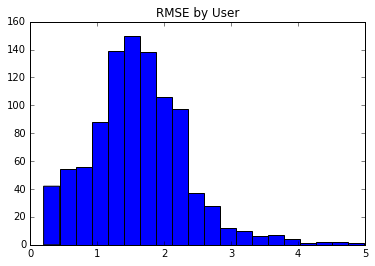

In [54]:
rmsevals = rmse_results['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_user']['count']]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

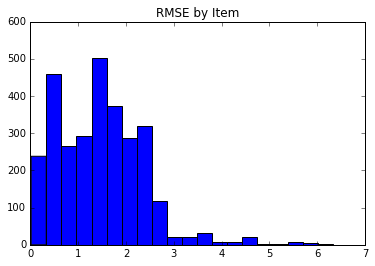

In [58]:
rmsevals = rmse_results['rmse_by_item']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_item']['count']]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by Item')
plt.show()

We can see we have a solid low RMSE for our model.  This is in both users and titles.  This model looks good.

Is it actually better than the previous item-item matrix?  Lets compare.

In [60]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00816326530612 | 0.00228370835514 |
|   2    | 0.00816326530612 | 0.00363217847912 |
|   3    | 0.00884353741497 | 0.00520952141987 |
|   4    | 0.00918367346939 | 0.00619075806294 |
|   5    | 0.00877551020408 | 0.00753501754496 |
|   6    | 0.00901360544218 | 0.00931829721001 |
|   7    | 0.00860058309038 | 0.0102770557134  |
|   8    | 0.00854591836735 | 0.0121712695965  |
|   9    | 0.00850340136054 |  0.014399160753  |
|   10   | 0.00867346938776 | 0.0151578627362  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 8.01373279725767)

Per User RMSE (best)
+--------+-------+------+
|   id   | count | rmse |
+--------+-------+------+
| 200568 |   1   | 3.0  |
+--------+-------+------+
[1 rows x 3 columns]


We can see the vast different in the two models.  The User-Item matrix is better in every facit than the Item-Item matrix.  So we will be sticking with the User-Item matrix.

## Modeling and Evaluation 4 - Summarize the Ramifications.

We have built three different models for our recommender system.  We have built a item-item matrix, a user-user matrix, and finally a User-Item martix.  We test all three models with precision, recall, and RMSE.  As we built the different models we checked the results.  each iteration of the model was better than the last one. Between the Item-Item to the User-Item we can see that every portion of the model improved.


## Deployment

The model came out came out pretty good in the end.  We achieved the results in our target range.  We would like a stronger precision.  It would take a more indepth look at the data to increase it.  This might be the best this dataset can give us.

To deploy our model we would use it in abook store, both online and in store.  For in store use we would use a kiosk where users can input and rate books they have read and recieve recommendations of books in stock to read.  

With some minor changes thsi model can possibly work with other simple recommender systems, like movies, television shows, etc.

For the best accuracy users need to continuely colect the data from users about the ratings about the items recommended to add to the datasetr and capture new releases.

The model should be continuely updated, but as books are not released foten there is no need for updating often.  We recommend updating the model either weekly or semi-weekly.

## Exceptional Work

Don't have anything for this section.  Looking into buildin SGraph of users with ratings similiar to each other but the data is not in the right format.